# Auditing a Speech-to-Text API
*By Ariana Rosario (ar943)*


## Introduction
### Google's Speech-to-Text API
The Speech-to-Text API is one of GCP's Free Tier products (up to 60 mins/mo) that generates transcribes text from audio. Besides the transcription, the API response also includes metadata such as the confidence score which I included into the results dataframe in case it could come in handy during the analysis. Here's more information about the API: https://cloud.google.com/speech-to-text

### The Data
I initially wanted to test the API using **Facebook's voxpopuli dataset** since it included rich demographic information about the speakers such as accents and native language. I wanted to test the *API's performance for non-native English speakers*, (especially for native Spanish speakers since it was relatable). However, after dealing with multiple issues loading the data, I ultimately decided to use a different dataset. Here's more information about voxpopuli: https://huggingface.co/datasets/facebook/voxpopuli

#### Mozilla's Common Voice Dataset
In the end, I went with **Mozilla's Common Voice dataset** which is widely used for speech recognition tasks. The dataset consists of audio clips and their corresponding metadata including the "ground truth" transcription as well as information about the speaker (such as Age and Gender). While I wouldn't be able to test the API's performance for non-native English speakers with this dataset, I thought could potentially observe *differences across gender groups.* Here's more information about the dataset: https://commonvoice.mozilla.org/en/datasets

### Hypothesis
Given that the API was developed by Google, and it's supposedly used in their own products, **I expect it to perform decently well.** There's also the fact that the dataset is pretty popular (although I downloaded the Delta Segment 16.1 subset which only includes the most recent entries). 
However, I'm curious to see whether there are any **differences in how the API performs for speakers of different genders.**

## Code

In [1]:
# import statements

import pandas as pd
import os
import io
import argparse

# setting  up the google cloud client library for the speech-to-text API
from google.cloud import speech
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'creds.json' #

### Helper Functions

In [2]:
# function to transcribe the file by calling the Google speech-to-text API

def transcribe_file(speech_file: str) -> speech.RecognizeResponse:
    """Transcribe the given audio file."""
    client = speech.SpeechClient()

    with open(speech_file, "rb") as audio_file:
        content = audio_file.read()

    audio = speech.RecognitionAudio(content=content)
    config = speech.RecognitionConfig(
        encoding=speech.RecognitionConfig.AudioEncoding.ENCODING_UNSPECIFIED,
        sample_rate_hertz=16000,
        language_code="en-US",
    )

    response = client.recognize(config=config, audio=audio)

    # Each result is for a consecutive portion of the audio. Iterate through
    # them to get the transcripts for the entire audio file.
    for result in response.results:
        # The first alternative is the most likely one for this portion.
        print(f"Transcript: {result.alternatives[0].transcript}")

    return response

In [3]:
# helper function to select and format API response for the dataframe

def transcribe_row(row):
    path = row['full_path']
    response = transcribe_file(path)
    transcript = response.results[0].alternatives[0].transcript
    confidence = response.results[0].alternatives[0].confidence
    return transcript, confidence

### Testing the API
I recorded a quick audio clip to test that the API client was properly set up and authenticated.

In [17]:
test_response = transcribe_file('test_recording.mp3')

Transcript: hello hello this is a test
Transcript:  let's see if it comes up with anything


### Loading and Preprocessing Data

In [4]:
# reading the metadata file containing only validated speech files
raw_speech_metadata = pd.read_csv('speech_data/validated.tsv', sep='\t')
raw_speech_metadata.describe(include='all')

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,variant,locale,segment
count,3408,3408,3408,3408.000000,3408.000000,3079,3076,3188,0.0,3408,0.0
unique,377,3408,3407,NaN,NaN,7,3,87,NaN,1,NaN
top,cf166b2a376b2518887f5a2e3c347a69f495260309ac27...,common_voice_en_39584989.mp3,This is actually a type of coastal upwelling.,NaN,NaN,twenties,male,"Southern African (South Africa, Zimbabwe, Nami...",NaN,en,NaN
freq,543,1,2,NaN,NaN,1616,1528,1164,NaN,3408,NaN
mean,NaN,NaN,NaN,2.912265,0.101526,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,2.504400,0.526066,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,3.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# cleaning the metadata file
speech_metadata = raw_speech_metadata.copy()
cols_to_keep = ['path', 'sentence','gender']
speech_metadata = speech_metadata[cols_to_keep]
speech_metadata = speech_metadata.dropna()

# adding the full path and confirming the audio file exists in directory
speech_metadata['full_path'] = 'speech_data/clips/' + speech_metadata['path']
speech_metadata['in_folder?'] = speech_metadata['full_path'].apply(lambda x: os.path.exists(x))
speech_metadata = speech_metadata[speech_metadata['in_folder?'] == True]
speech_metadata = speech_metadata.drop(columns=['in_folder?'])

speech_metadata.describe(include='all')

,path,sentence,gender,full_path
count,64,64,64,64
unique,64,64,2,64
top,common_voice_en_38491074.mp3,To its east stands Trinity College Dublin.,male,speech_data/clips/common_voice_en_38491074.mp3
freq,1,1,44,1


In [6]:
# segmenting the data by gender
female_speech = speech_metadata[speech_metadata['gender'] == 'female'].sample(20)
male_speech = speech_metadata[speech_metadata['gender'] == 'male'].sample(20)

### Generating transcriptions via Google's Speech-to-Text API

In [7]:
male_speech[['transcript','confidence']] = male_speech.apply(transcribe_row, axis=1, result_type='expand')

Transcript: to its East stands Trinity College Dublin
Transcript: many times he actually appeared in films uncredited
Transcript: the city council consists of 5 members each elected from single member districts
Transcript: the term combo box is sometimes used to mean drop-down list
Transcript: there are also plenty more in the vicinity of the lock
Transcript: dining facilities are located in Memorial Hall and the Student Center
Transcript: the 2 ships are then passed through the darning Ellis to Constantinople
Transcript: Sam Mills was born in Neptune City New Jersey
Transcript: potassium ferricyanide is a non-toxic and is not decomposed to cyanide in the body
Transcript: future films will use split screen for that purpose
Transcript: during the following year boiler forces unsuccessfully attempted to regain the territory through negotiation
Transcript: they think themselves upon it with frantic Fury straining every nerve
Transcript: but the phenomenon has been traced back to before th

In [8]:
female_speech[['transcript','confidence']] = female_speech.apply(transcribe_row, axis=1, result_type='expand')

Transcript: Russia has blocked access to aroid
Transcript: for more information of the disaster
Transcript:  See Marshall University as disaster
Transcript: there's another word in the lyrics that stands out
Transcript: hi then was born in San Antonio Texas
Transcript: the Beast is a demon portrayed by
Transcript:  Vemma Kish
Transcript: virginie later wrote that the film fell between 2 tools
Transcript: road conditions vary immensely and maintenance is sometimes deficient
Transcript: this collection compromises mostly architectural and sculptural images both exclusive and secular
Transcript: the road is now called Sam Cooper bite
Transcript:  and is owned by the city
Transcript: for the reminder of the war current delayed Patrol in the Cumberland River
Transcript: this means that no well-defined combustion initiate a provides Direct Control
Transcript: geogan is claims however that he to
Transcript:  it aside
Transcript: a conditionally distribution can be formed from a generative mod

In [13]:
# merging the dataframes

transcribed_speech = pd.concat([female_speech,male_speech], axis=0)
transcribed_speech.sample(4)

,path,sentence,gender,full_path,transcript,confidence
792,common_voice_en_38499436.mp3,"Marriages were arranged, the groom's parents s...",male,speech_data/clips/common_voice_en_38499436.mp3,marriages were arranged the groom's parents se...,0.874231
791,common_voice_en_38499331.mp3,They fling themselves upon it with frantic fur...,male,speech_data/clips/common_voice_en_38499331.mp3,they think themselves upon it with frantic Fur...,0.892599
944,common_voice_en_38492457.mp3,This means that no well-defined combustion ini...,female,speech_data/clips/common_voice_en_38492457.mp3,this means that no well-defined combustion ini...,0.823507
946,common_voice_en_38492498.mp3,The unit took part in the Battle of Belchite.,female,speech_data/clips/common_voice_en_38492498.mp3,do you took part in the battle of belchi,0.824990


### Analyzing API Performance

In [21]:
# testing jiwer (setup code from https://pypi.org/project/jiwer/
from jiwer import wer

reference = "hello world"
hypothesis = "hello duck"

error = wer(reference, hypothesis)
error

0.5

In [18]:
# helper function to add the WER to the results dataframe
def calculate_wer(row):
    reference = row['sentence']
    hypothesis = row['transcript']
    wer_score = wer(reference, hypothesis)
    return wer_score

transcribed_speech['WER'] = transcribed_speech.apply(calculate_wer, axis=1)
transcribed_speech.sample(5)

,path,sentence,gender,full_path,transcript,confidence,WER
956,common_voice_en_38492682.mp3,Phil Dunne later wrote that the film fell betw...,female,speech_data/clips/common_voice_en_38492682.mp3,virginie later wrote that the film fell betwee...,0.701307,0.363636
792,common_voice_en_38499436.mp3,"Marriages were arranged, the groom's parents s...",male,speech_data/clips/common_voice_en_38499436.mp3,marriages were arranged the groom's parents se...,0.874231,0.230769
940,common_voice_en_38492279.mp3,"For the remainder of the war, ""Carondelet"" pat...",female,speech_data/clips/common_voice_en_38492279.mp3,for the reminder of the war current delayed Pa...,0.807145,0.583333
945,common_voice_en_38492475.mp3,"The road is now called Sam Cooper Boulevard, a...",female,speech_data/clips/common_voice_en_38492475.mp3,the road is now called Sam Cooper bite,0.670521,0.571429
2374,common_voice_en_38501259.mp3,"The term ""combo box"" is sometimes used to mean...",male,speech_data/clips/common_voice_en_38501259.mp3,the term combo box is sometimes used to mean d...,0.861804,0.454545


In [22]:
# testing jiwer transforms 
# per Medium article https://medium.com/@johnidouglasmarangon/how-to-calculate-the-word-error-rate-in-python-ce0751a46052

transforms = jiwer.Compose(
    [
        jiwer.ExpandCommonEnglishContractions(),
        jiwer.RemoveEmptyStrings(),
        jiwer.ToLowerCase(),
        jiwer.RemoveMultipleSpaces(),
        jiwer.Strip(),
        jiwer.RemovePunctuation(),
        jiwer.ReduceToListOfListOfWords(),
    ]
)

# helper function to add the WER to the results dataframe with transforms
def calculate_wer_tr(row):
    reference = row['sentence']
    hypothesis = row['transcript']
    wer_score = wer(reference, hypothesis,
                    truth_transform=transforms,
                    hypothesis_transform=transforms)
    return wer_score

transcribed_speech['WER_transforms'] = transcribed_speech.apply(calculate_wer, axis=1)
transcribed_speech.sample(5)

,path,sentence,gender,full_path,transcript,confidence,WER,WER_transforms
941,common_voice_en_38492289.mp3,It also inhabits a majority of Tasmania.,female,speech_data/clips/common_voice_en_38492289.mp3,it also inhabits a majority of Tasmania,0.867259,0.285714,0.285714
957,common_voice_en_38492685.mp3,Every jolt was agony to her.,female,speech_data/clips/common_voice_en_38492685.mp3,every child was a GI to her,0.817252,0.833333,0.833333
2375,common_voice_en_38501272.mp3,Dining facilities are located in Memorial Hall...,male,speech_data/clips/common_voice_en_38501272.mp3,dining facilities are located in Memorial Hall...,0.942639,0.181818,0.181818
950,common_voice_en_38492588.mp3,Giblin was raised in Newark and attended Seton...,female,speech_data/clips/common_voice_en_38492588.mp3,Gabriel was raised in,0.661635,0.727273,0.727273
951,common_voice_en_38492591.mp3,"For more information on the disaster, see Mars...",female,speech_data/clips/common_voice_en_38492591.mp3,for more information of the disaster,0.971466,0.727273,0.727273


<Axes: xlabel='WER', ylabel='WER_transforms'>

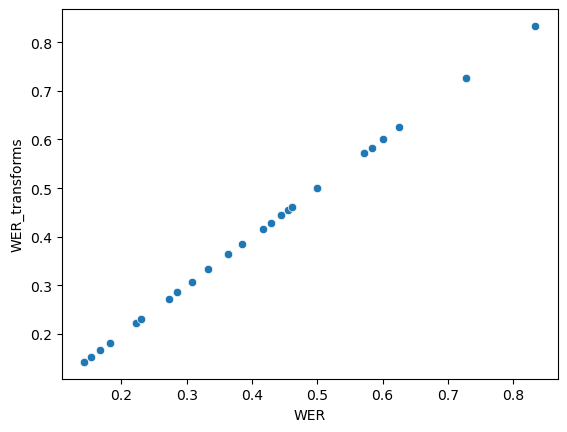

In [52]:
# scatter plot of WER and WER_transforms to see if there is a difference

sns.scatterplot(data=transcribed_speech, x='WER', y='WER_transforms')


In [53]:
# no difference so I'll ignore the WER with transforms

Text(0, 0.5, '')

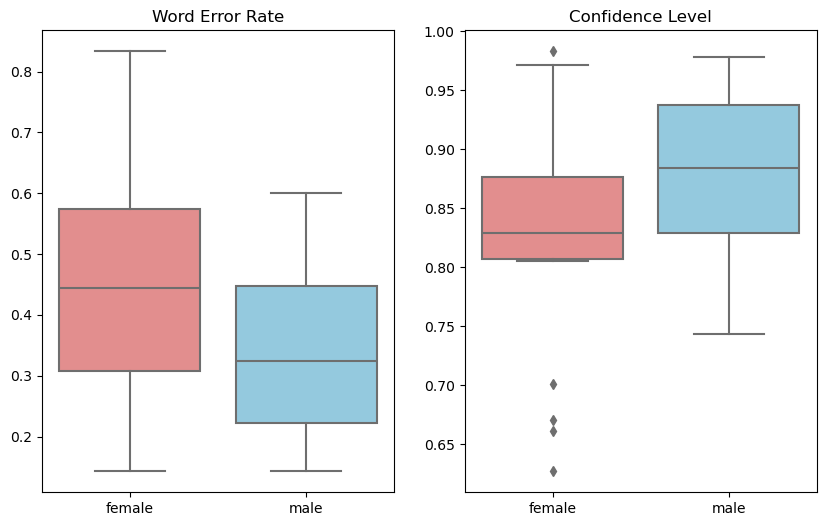

In [48]:
# creating plots of WER and confidence across gender
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10,6))

sns.boxplot(ax=ax[0], data=transcribed_speech, x='gender', y='WER', palette=['lightcoral','skyblue'])
ax[0].set_title('Word Error Rate')
ax[0].set_xlabel('')
ax[0].set_ylabel('')

sns.boxplot(ax=ax[1], data=transcribed_speech, x='gender', y='confidence',  palette=['lightcoral','skyblue'])
ax[1].set_title('Confidence Level')
ax[1].set_xlabel('')
ax[1].set_ylabel('')

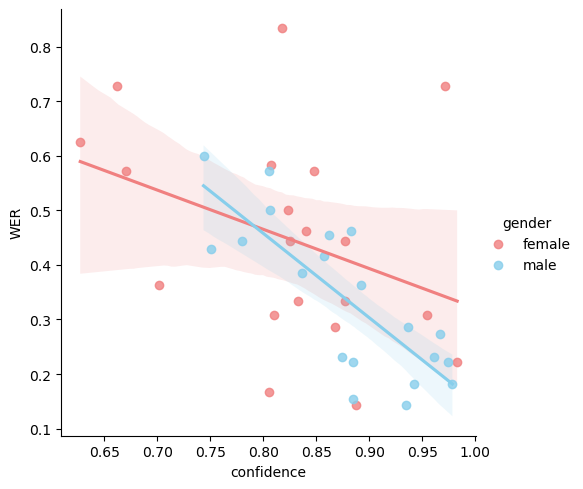

In [51]:
# plotting WER vs confidence

sns.lmplot(data=transcribed_speech, x='confidence', y='WER', hue='gender', palette=['lightcoral','skyblue'])

## Discussion

As seen in the plots above, **the API performed differently across gender groups.** 

For once, the median Word Error Rate (WER) for male speakers was fairly decent at ~30% while one for female speakers was significantly higher at ~45%. Another thing I noticed was that the confidence scores provided by the API were slightly higher for men (almost 90% median confidence score) vs. women (~83% median confidence score). 

Additionally, in both cases, the confidence scores were negatively correlated with the WER *(which makes sense)*. However, the correlation was stronger for male speakers and female speakers has more outliers.

In the end, I didn't expect to see such a big difference in performance. I figured that, at this point, these models would be incredibly good at transcribing speech.

### Possible Explanations
My initial guess is that the difference in performance across gender could be due to the model being trained on a dataset that's not representative of the general population. In other words, **maybe there wasn't enough data from women in the training dataset.**

Another thing that comes to mind is that women's tone and pitch can be considerably different than men's and if there wasn't enough data from female speakers, the model might not have been able to learn their speech patterns as well.

### Limitations
While there are considerable differences in the API's performance for male and female speakers, it's important to note that *the dataset I used is very small.*

I only transcribed 20 random audio clips for each gender group, so it's very likely that **there weren't enough data points for the results to be significant.**

Also, I only used WER and confidence scores to evaluate the API. There are probably many other metrics to consider in order to get a more in-depth analysis.

## References

#### Researching Datasets
* https://paperswithcode.com/datasets?mod=audio&lang=english
* https://web.stanford.edu/class/cs224s/datasets/
* https://commonvoice.mozilla.org/en/datasets
* https://huggingface.co/datasets/common_voice

#### Setting up GCP
* https://cloud.google.com/speech-to-text
* https://youtu.be/xKvffLRSyPk?si=LXrXfJyLCvzH1J62
* https://youtu.be/izdDHVLc_Z0?si=qcRQL4QHZJsFX4LB

#### Speech-to-text API Tutorial
* https://youtu.be/jBbLon5esbE?si=pNd4Bsc6aCUBftUO

#### Word Error Rate
* https://pypi.org/project/jiwer/
* https://medium.com/@johnidouglasmarangon/how-to-calculate-the-word-error-rate-in-python-ce0751a46052

#### Plotting
* https://seaborn.pydata.org/
* https://python-charts.com/correlation/scatter-plot-regression-line-seaborn/